# "From First Principles"

## Settings

In [10]:
ground_truth_path = '../data/eval/ground_truth_gpt5nano.json'
documents_path = '../data/canonical/all_documents.json'

In [11]:
# For loading in modules pre-defined in scripts
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[0]  # rag-google-io
sys.path.insert(0, str(PROJECT_ROOT))

print("Added to PYTHONPATH:", PROJECT_ROOT)

Added to PYTHONPATH: /home/al/Documents/rag-google-io


In [13]:
#check
import os

print("CWD:", os.getcwd())
print("Notebook path:", Path.cwd())

CWD: /home/al/Documents/rag-google-io/evaluation_offline
Notebook path: /home/al/Documents/rag-google-io/evaluation_offline


## Load Datasets

In [14]:
import json

# Open the file for reading ('r')
with open(ground_truth_path, 'r') as file:
    ground_truth_dataset = json.load(file)

In [15]:
type(ground_truth_dataset)

list

In [16]:
ground_truth_dataset[0]

{'query': "What were the main topics and components discussed in Google's AI Stack for Developers session at Google I/O, including foundation models and the developer frameworks mentioned?",
 'relevant_doc_ids': ['4TE-KFXvhAk__chunk_000']}

In [17]:
# Open the file for reading ('r')
with open(documents_path, 'r') as file:
    documents = json.load(file)

In [18]:
type(documents)

list

In [19]:
documents[0]

{'id': '4TE-KFXvhAk__chunk_000',
 'video_id': '4TE-KFXvhAk',
 'title': "Google I/O 2025 - What's New in AI",
 'timestamp_start': 0.0,
 'timestamp_end': 139.04,
 'text': "[MUSIC PLAYING] JOANA CARRASQUEIRA:\nHello, everyone. My name is Joana Carrasqueira,\nand I lead Developer Relations at Google DeepMind. JOSH GORDON: Hi, everyone. I'm Josh. JOANA CARRASQUEIRA:\nAnd we're very excited to welcome you to\nour session, Google's AI Stack for Developers. We'll start by giving you a\nquick overview of Google's AI stack. Who's at I/O for the first time? Can I see some hands up? Oh, OK. Welcome to Google\nI/O. It's a pleasure to have you with us today. So we'll start by giving\nyou an overview of Google's end-to-end ecosystem of AI. And as you know, we've\nbeen leading the way in AI for decades, since we\nopen-sourced TensorFlow in 2015, from when we published our\nfield-defining research with transformers\nin 2017, to Gemini. And we are now in\nthe Gemini era. So we've been releasing a lot. R

##### check if there are documents in the ground truth that have more than 1 revelant document / chunk

In [20]:
extract_relevant_doc_ids = []
for i in ground_truth_dataset:
    doc_id=i['relevant_doc_ids']
    print(doc_id)
    extract_relevant_doc_ids.append(doc_id)

['4TE-KFXvhAk__chunk_000']
['4TE-KFXvhAk__chunk_000']
['4TE-KFXvhAk__chunk_001']
['4TE-KFXvhAk__chunk_001']
['4TE-KFXvhAk__chunk_002']
['4TE-KFXvhAk__chunk_002']
['4TE-KFXvhAk__chunk_003']
['4TE-KFXvhAk__chunk_003']
['4TE-KFXvhAk__chunk_004']
['4TE-KFXvhAk__chunk_004']


In [21]:
type(extract_relevant_doc_ids)

list

## Evaluation - Main Part
using Qdrant

#### Assumptions:
* You already have a running Qdrant instance

* Your collection name is known (e.g. "google-io-transcripts")

* Your payload contains "doc_id" (as in your build_points function)

* You are using cosine similarity with normalized embeddings

In [22]:
from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer
import numpy as np

In [23]:
# Qdrant connection
qdrant = QdrantClient(
    host="localhost",
    port=6333,
)

COLLECTION_NAME = "google-io-transcripts"

# Embedding model (must match indexing time)
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [24]:
from retrieval.vector_search0_2 import vector_search

In [25]:
all_results = []  # store all queries' retrieved docs, cosine, etc.

TOP_K = 5

from tqdm import tqdm
import numpy as np

for q in tqdm(ground_truth_dataset):
    query = q["query"]
    relevant_doc_ids = set(q["relevant_doc_ids"])

    # Retrieve top-K from Qdrant
    retrieved_docs = vector_search(query, top_k=TOP_K, with_vectors=True)

    retrieved_doc_ids = []
    relevance = []
    cosine_scores = []

    # Encode query once
    query_vec = embedding_model.encode(query, normalize_embeddings=True)

    for hit in retrieved_docs:
        doc_id = hit.payload["doc_id"]
        retrieved_doc_ids.append(doc_id)
        relevance.append(doc_id in relevant_doc_ids)

        # Per-doc cosine similarity
        doc_vec = np.array(hit.vector)
        cosine = float(np.dot(query_vec, doc_vec))
        cosine_scores.append(cosine)

    all_results.append({
        "query": query,
        "retrieved_doc_ids": retrieved_doc_ids,
        "relevance": relevance,
        "cosine_scores": cosine_scores,
        "relevant_doc_ids": list(relevant_doc_ids)
    })

100%|█████████████████████████████████████████| 10/10 [00:03<00:00,  3.11it/s]


In [26]:
# Example for the first query
first_query_results = all_results[0]

print(first_query_results["query"])
print(first_query_results["retrieved_doc_ids"])
print(first_query_results["relevance"])
print(first_query_results["cosine_scores"])

What were the main topics and components discussed in Google's AI Stack for Developers session at Google I/O, including foundation models and the developer frameworks mentioned?
['4TE-KFXvhAk__chunk_000', '4TE-KFXvhAk__chunk_017', '4TE-KFXvhAk__chunk_019', '4TE-KFXvhAk__chunk_001', 'gHHjDRDNUNU__chunk_007']
[True, False, False, False, False]
[0.6397025660964655, 0.5994340599856143, 0.5812045879216559, 0.547020737090304, 0.5116544582349252]


In [27]:
from tqdm import tqdm

TOP_K = 5
relevance_total = []

for q in tqdm(ground_truth_dataset):
    query = q["query"]
    relevant_doc_ids = set(q["relevant_doc_ids"])

    # Retrieve top-K from Qdrant
    results = vector_search(query, top_k=TOP_K, with_vectors=True)

    # Build relevance vector: [True/False per rank]
    relevance = [
        hit.payload.get("doc_id") in relevant_doc_ids
        for hit in results
    ]

    relevance_total.append(relevance)

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 20.17it/s]


In [28]:
relevance_total

[[True, False, False, False, False],
 [True, False, False, False, False],
 [False, False, False, False, False],
 [False, True, False, False, False],
 [False, True, False, False, False],
 [False, False, False, True, False],
 [True, False, False, False, False],
 [False, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False]]

#### **Recall@k**

In [29]:
import numpy as np

recall_at_k = np.mean([any(row) for row in relevance_total])

In [30]:
recall_at_k

np.float64(0.8)

#### **MRR@k**

In [31]:
def rr(row):
    for i, val in enumerate(row):
        if val:
            return 1.0 / (i + 1)
    return 0.0

mrr = np.mean([rr(row) for row in relevance_total])

In [32]:
mrr

np.float64(0.625)

#### **NDCG score**

In [33]:
import numpy as np
from sklearn.metrics import ndcg_score

y_true = np.array(relevance_total, dtype=int)

y_scores = np.tile(
    np.linspace(1, 0.1, TOP_K),
    (y_true.shape[0], 1)
)

ndcg = ndcg_score(y_true, y_scores, k=TOP_K)
print(f"NDCG@{TOP_K}: {ndcg:.3f}")

NDCG@5: 0.669


# Building prompt and LLM

In [34]:
retrieved_docs

[ScoredPoint(id=4, version=1, score=0.5159571, payload={'doc_id': '4TE-KFXvhAk__chunk_004', 'video_id': '4TE-KFXvhAk', 'title': "Google I/O 2025 - What's New in AI", 'timestamp_start': 502.44, 'timestamp_end': 656.4300000000001, 'text': "So if we go to Google AI Studio\nhere, if we go into Build, and Mumble Jumble is\nsomething that we've literally just created, and\nit's one of my favorite apps. So Mumble Jumble is one\nof those applications that with just natural\nlanguage allows you to interact with\nthe model so you can build those more dynamic and\ninteractive audio experiences. So let's have a look. So, first of all, it uses 2.5\npreview native audio dialog. You can choose if it's easy to\ninterrupt or hard to interrupt. And then you can come and\npick your voice, hi pitch. So there's multiple things\nthat you can play with and then you can customize. I really like the fox, so let's\ngo ahead and pick the fox. Let's get the cowboy. Happy because we're\nat Google I/O. We're all su

### Build prompt for RAG

In [35]:
def build_prompt(query, retrieved_docs):
    """
    Create a RAG-style prompt using top-K retrieved documents.
    """
    context = "\n---\n".join([hit.payload["text"][:1000] for hit in retrieved_docs])
    
    prompt = f"""
You're a helpful assistant. Answer the QUESTION using ONLY the CONTEXT from the retrieved documents.

QUESTION:
{query}

CONTEXT:
{context}
""".strip()
    return prompt

### Generate answer using LLM

In [36]:
import getpass

try:
    API_KEY = getpass.getpass()
except Exception as error:
    print('ERROR', error)
else:
    print('API_KEY entered')

 ········


API_KEY entered


In [37]:
from openai import OpenAI

client = OpenAI(api_key=API_KEY)  # Make sure OPENAI_API_KEY is set

def rag_answer(query, retrieved_docs, model="gpt-5-nano"):
    prompt = build_prompt(query, retrieved_docs)
    
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            # temperature=0  # ❌ remove this line for gpt-5-nano
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("RAG LLM error:", e)
        return ""

In [38]:
query = "What were the main topics and components discussed in Google's AI Stack for Developers session at Google I/O, including foundation models and the developer frameworks mentioned?"

In [39]:
answer = rag_answer(query, retrieved_docs, model="gpt-5-nano")

In [40]:
answer[:1000]

'- Foundation models and history mentioned\n  - Gemini (the Gemini family) as the current generation of foundation models\n  - Gemma (another model in the stack) with its own cookbook\n  - A nod to the historical foundation models: TensorFlow (open-sourced in 2015) and transformers (field-defining research in 2017)\n\n- Main topics discussed in the session\n  - An overview of Google’s end-to-end AI stack and the shift into the Gemini era\n  - Gemini API capabilities, including:\n    - Text-to-speech with controllable emotion and style (dynamic, expressive audio)\n    - Availability on live API and on another API for real-time generation\n  - Enhanced tooling and capabilities:\n    - Grounding the model with Google Search\n    - Code Execution integrated with the API\n    - URL context to provide depth from web pages\n    - Ability to chain tools to build search agents\n  - Developer experience and starting points:\n    - Gemini Developer API as the easiest way to get started\n    - Gen

## Final Evaluations

In [41]:
def compute_cosine(query_vec, doc_vec):
    """Compute cosine similarity between two vectors"""
    return float(np.dot(query_vec, doc_vec) / (np.linalg.norm(query_vec) * np.linalg.norm(doc_vec)))

In [42]:
def compute_avg_cosine(query, results):
    """Average cosine similarity of top-K retrieved docs"""
    query_vec = embedding_model.encode(query, normalize_embeddings=True)
    doc_vecs = [np.array(hit.vector) for hit in results if hasattr(hit, "vector")]
    if not doc_vecs:
        return 0.0
    return float(np.mean([compute_cosine(query_vec, v) for v in doc_vecs]))

#### LLM judge

In [46]:
def llm_judge(query, retrieved_docs, model="gpt-5-nano"):
    """
    Ask the LLM to rate the quality of retrieved documents for the question.
    Returns 1-5
    """
    retrieved_texts = "\n---\n".join([hit.payload["text"][:1000] for hit in retrieved_docs if "text" in hit.payload])
    prompt = f"""
    You are an expert evaluating document retrieval.
    Question: {query}
    
    Retrieved documents:
    {retrieved_texts}
    
    Rate how well these documents answer the question on a scale from 1 (very poor) to 5 (excellent).
    Only respond with a single integer.
    """
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            #temperature=0 # ❌ remove this line for gpt-5-nano
        )
        score = int(response.choices[0].message.content.strip())
        return max(1, min(score, 5))
    except Exception as e:
        print("LLM scoring error:", e)
        return None


In [44]:
# # Loop over ground truth
# results_all = []

# for q in tqdm(ground_truth_dataset):
#     query = q["query"]
#     relevant_doc_ids = set(q["relevant_doc_ids"])
    
#     # Retrieve top-K docs
#     retrieved_docs = vector_search(query, top_k=TOP_K)
    
#     # Compute Recall@K, MRR, NDCG (you already did)
    
#     # Generate RAG answer
#     answer = rag_answer(query, retrieved_docs)
    
#     # Ask LLM to judge retrieval quality
#     llm_score = llm_judge(query, retrieved_docs)
    
#     results_all.append({
#         "query": query,
#         "relevant_doc_ids": list(relevant_doc_ids),
#         "retrieved_doc_ids": [hit.payload["doc_id"] for hit in retrieved_docs],
#         "rag_answer": answer,
#         "llm_score": llm_score
#     })


In [102]:
# Evaluation loop - loop over ground truth
# -----------------------------
results_all = []

for item in tqdm(ground_truth_dataset, desc="Evaluating queries"):
    query = item["query"]
    relevant_ids = item.get("relevant_doc_ids", [])

    # Retrieve top-K docs
    retrieved_docs = vector_search(query, top_k=TOP_K, with_vectors=True)

    # Compute per-query cosine similarity
    avg_cos = compute_avg_cosine(query, retrieved_docs)

    # Prepare text for LLM judge (first 1000 chars per doc)
    retrieved_texts = "\n---\n".join([hit.payload["text"][:1000] for hit in retrieved_docs if "text" in hit.payload])

    # Get LLM score
    llm_score = llm_judge(query, retrieved_docs)

    # Recall@K
    retrieved_ids = [hit.payload["doc_id"] for hit in retrieved_docs if "doc_id" in hit.payload]
    recall_at_k = int(any(rid in relevant_ids for rid in retrieved_ids))


    
    # intermediate calcs for MRR and NDCG:
    retrieved_ids = [hit.payload["doc_id"] for hit in retrieved_docs if "doc_id" in hit.payload]
    retrieved_ids = []
    relevance = []

    for hit in retrieved_docs:
        doc_id = hit.payload.get("doc_id")
        retrieved_ids.append(doc_id)
        relevance.append(int(doc_id in relevant_ids))  # True or False -> 1 or 0

    def reciprocal_rank(relevance):
        for i, rel in enumerate(relevance, start=1):
            if rel:
                return 1.0 / i
        return 0.0


    # MRR@K
    mrr_at_k = reciprocal_rank(relevance)
    
    # NDCG@K
    y_true = np.array([relevance])
    y_scores = np.array(
        [np.linspace(1, 0.1, TOP_K)]
    )
    ndcg_at_k = ndcg_score(y_true, y_scores, k=TOP_K)

    # Save results
    results_all.append({
        "query": query,
        "relevant_doc_ids": relevant_ids,
        "retrieved_doc_ids": retrieved_ids,
        "recall_at_5": recall_at_k,
        "mrr_at_k": mrr_at_k,
        "ndcg_at_k": ndcg_at_k,
        "avg_cosine": avg_cos,
        "llm_score": llm_score,
    })

Evaluating queries: 100%|█████████| 10/10 [01:12<00:00,  7.24s/it]


In [ ]:
# should save results_all and then just call it for visualisations

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
# -----------------------------
# Analysis & Plots
# -----------------------------
df = pd.DataFrame(results_all)

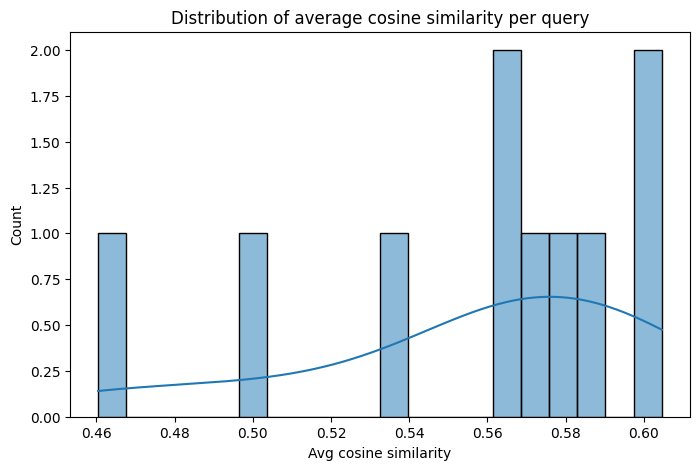

In [105]:
# Cosine similarity distribution
plt.figure(figsize=(8,5))
sns.histplot(df["avg_cosine"], kde=True, bins=20)
plt.title("Distribution of average cosine similarity per query")
plt.xlabel("Avg cosine similarity")
plt.ylabel("Count")
plt.show()

/tmp/ipykernel_5976/4236370447.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['avg_cosine'])


<Axes: xlabel='avg_cosine', ylabel='Density'>

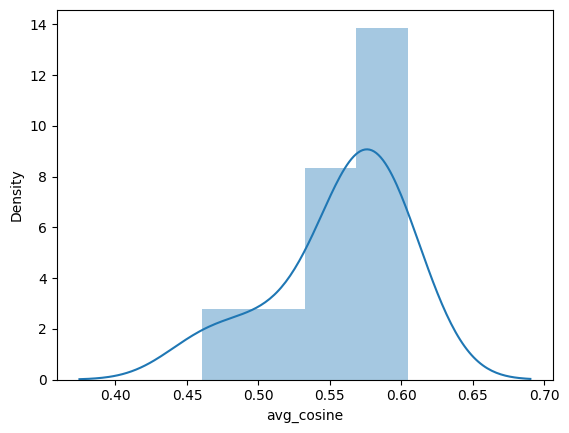

In [106]:
sns.distplot(df['avg_cosine'])

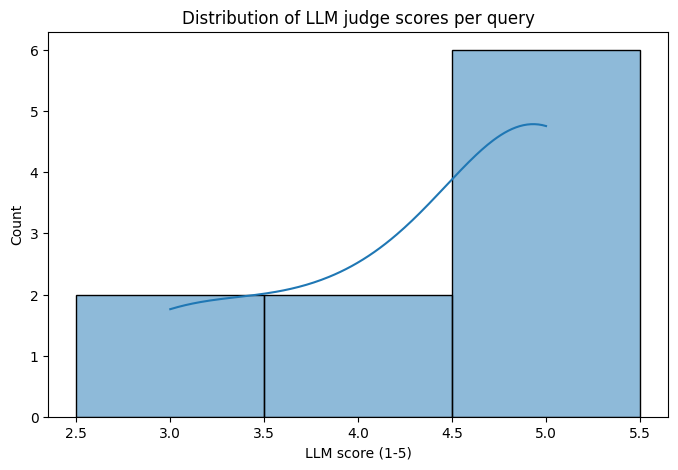

In [107]:
# LLM score distribution
plt.figure(figsize=(8,5))
sns.histplot(df["llm_score"], kde=True, bins=5, discrete=True)
plt.title("Distribution of LLM judge scores per query")
plt.xlabel("LLM score (1-5)")
plt.ylabel("Count")
plt.show()

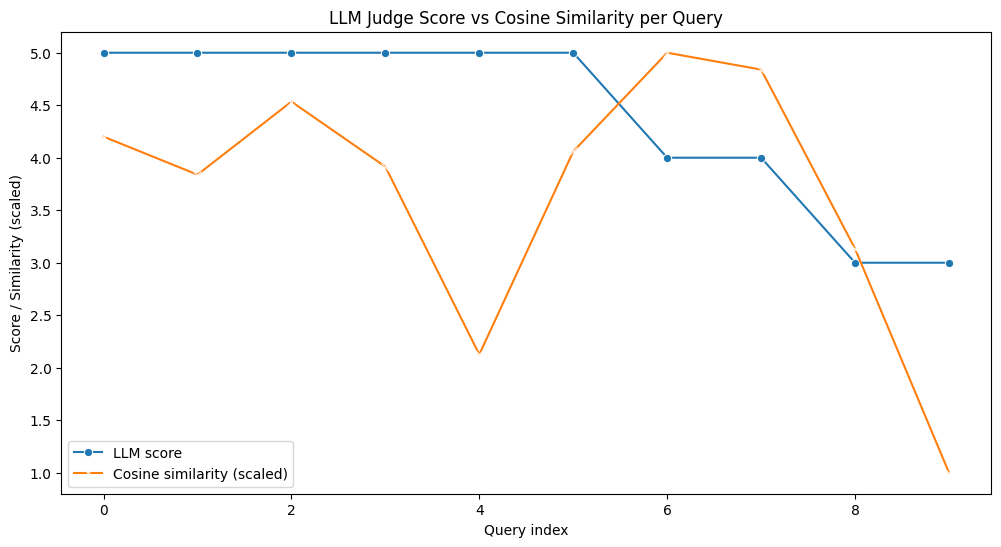

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your results (if not already loaded)
df = df#pd.read_json("data/eval/retrieval_llm_eval.json")

# Optional: normalize cosine similarity to 0-5 scale for better comparison
cos_min, cos_max = df["avg_cosine"].min(), df["avg_cosine"].max()
df["cosine_scaled"] = 1 + 4 * (df["avg_cosine"] - cos_min) / (cos_max - cos_min)  # scale to [1,5]

# Sort queries by LLM score or any other metric if desired
df_sorted = df.sort_values("llm_score", ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df_sorted, x=range(len(df_sorted)), y="llm_score", marker="o", label="LLM score")
sns.lineplot(data=df_sorted, x=range(len(df_sorted)), y="cosine_scaled", marker="x", label="Cosine similarity (scaled)")
plt.xlabel("Query index")
plt.ylabel("Score / Similarity (scaled)")
plt.title("LLM Judge Score vs Cosine Similarity per Query")
plt.legend()
plt.show()

In [109]:
df

,query,relevant_doc_ids,retrieved_doc_ids,recall_at_5,mrr_at_k,ndcg_at_k,avg_cosine,llm_score,cosine_scaled
0,What were the main topics and components discu...,[4TE-KFXvhAk__chunk_000],"[4TE-KFXvhAk__chunk_000, 4TE-KFXvhAk__chunk_01...",1,1.00,1.000000,0.575803,5,4.200613
1,Who were the presenters introducing Google's A...,[4TE-KFXvhAk__chunk_000],"[4TE-KFXvhAk__chunk_000, 4TE-KFXvhAk__chunk_01...",1,1.00,1.000000,0.562762,5,3.838709
2,What are Google Gemini models and how do Gemin...,[4TE-KFXvhAk__chunk_001],"[gHHjDRDNUNU__chunk_017, gHHjDRDNUNU__chunk_00...",0,0.00,0.000000,0.598818,4,4.839307
3,What does Google describe about tooling and in...,[4TE-KFXvhAk__chunk_001],"[4TE-KFXvhAk__chunk_017, 4TE-KFXvhAk__chunk_00...",1,0.50,0.630930,0.587823,5,4.534184
4,What new AI Studio features and Gemini API cap...,[4TE-KFXvhAk__chunk_002],"[4TE-KFXvhAk__chunk_003, 4TE-KFXvhAk__chunk_00...",1,0.50,0.630930,0.604609,4,5.000000
5,What updates were shared about the Gemini mode...,[4TE-KFXvhAk__chunk_002],"[gHHjDRDNUNU__chunk_022, gHHjDRDNUNU__chunk_00...",1,0.25,0.430677,0.565485,5,3.914260
6,What are the new Gemini API capabilities for t...,[4TE-KFXvhAk__chunk_003],"[4TE-KFXvhAk__chunk_003, gHHjDRDNUNU__chunk_00...",1,1.00,1.000000,0.570719,5,4.059519
7,How does Google AI Studio help developers test...,[4TE-KFXvhAk__chunk_003],"[4TE-KFXvhAk__chunk_006, 4TE-KFXvhAk__chunk_01...",0,0.00,0.000000,0.537331,3,3.132948
8,What is the Mumble Jumble app in Google AI Stu...,[4TE-KFXvhAk__chunk_004],"[4TE-KFXvhAk__chunk_004, 4TE-KFXvhAk__chunk_00...",1,1.00,1.000000,0.501055,5,2.126258
9,Where can I find a Google AI Studio demo featu...,[4TE-KFXvhAk__chunk_004],"[4TE-KFXvhAk__chunk_004, 4TE-KFXvhAk__chunk_01...",1,1.00,1.000000,0.460471,3,1.000000


In [110]:
df['cosine_scaled_llm_score__diff'] = df['cosine_scaled'] - df['llm_score']

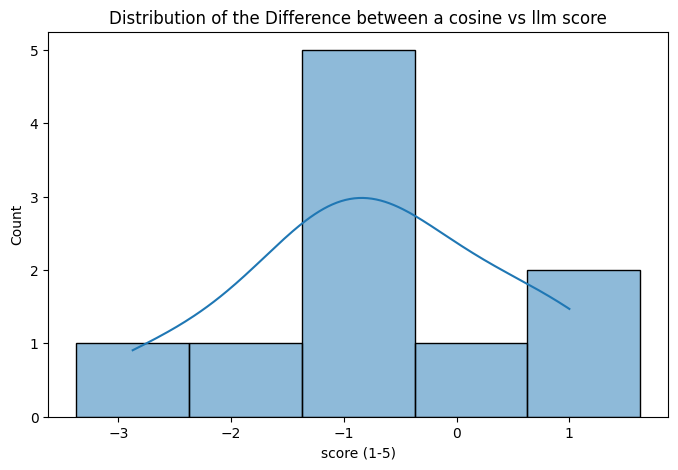

In [111]:
# High cosine, but low LLM => retrieval may be semantically similar, but not answering the question
plt.figure(figsize=(8,5))
sns.histplot(df["cosine_scaled_llm_score__diff"], kde=True, bins=5, discrete=True)
plt.title("Distribution of the Difference between a cosine vs llm score")
plt.xlabel("score (1-5)")
plt.ylabel("Count")
plt.show()

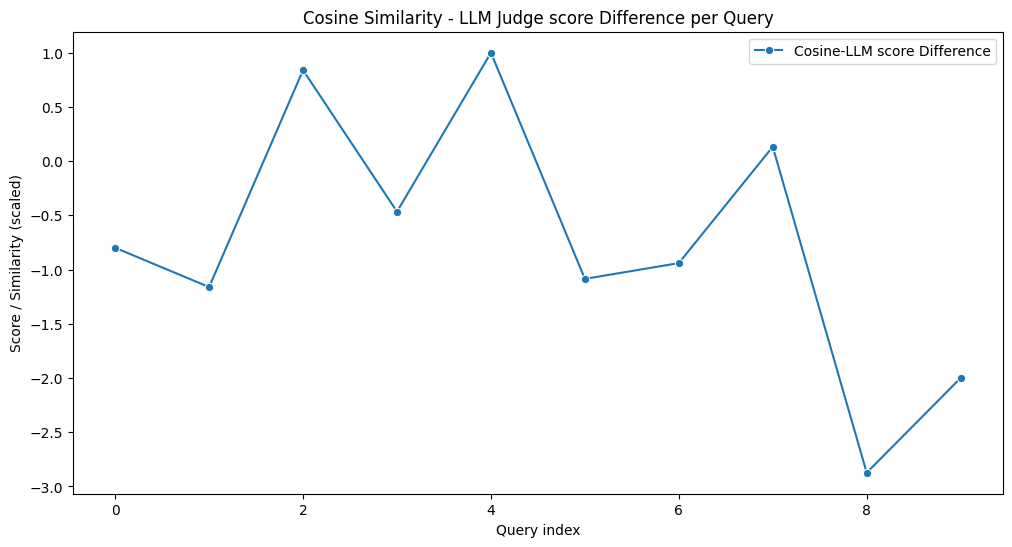

In [112]:
# Sort queries by LLM score or any other metric if desired
df_sorted = df#.sort_values("cosine_scaled_llm_score__diff", ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df_sorted, x=range(len(df_sorted)), y="cosine_scaled_llm_score__diff", marker="o", label="Cosine-LLM score Difference")
plt.xlabel("Query index")
plt.ylabel("Score / Similarity (scaled)")
plt.title("Cosine Similarity - LLM Judge score Difference per Query")
plt.legend()
plt.show()

In [76]:
df.iloc[4]

query                            What new AI Studio features and Gemini API cap...
relevant_doc_ids                                          [4TE-KFXvhAk__chunk_002]
retrieved_doc_ids                [4TE-KFXvhAk__chunk_003, 4TE-KFXvhAk__chunk_00...
recall_at_5                                                                      1
avg_cosine                                                                0.604609
llm_score                                                                        4
cosine_scaled                                                                  5.0
llm_score_cosine_scaler_diff                                                  -1.0
cosine_scaled_llm_score__diff                                                  1.0
Name: 4, dtype: object

In [77]:
df.iloc[4]['query']

'What new AI Studio features and Gemini API capabilities were announced, such as the Build tab that generates web apps and the new generative media experience?'

In [93]:
filtered_docs = [
    d for d in documents
    if "4TE-KFXvhAk__chunk_002" in d["id"]
]

relevant_doc_text = filtered_docs[0]['text']
print(relevant_doc_text.replace("\\n", "\n"))

it's really good at coding
and also more complex prompts. It leads coding
benchmarks including WebDev Arena leaderboard,
and it's really our most powerful model. Gemini 2.5 Flash, which
developers love it because of its
efficiency and speed, and it's now even better at
almost every single dimension. So we improved
all the benchmarks across reasoning, coding,
multimodality, and also long context. Then we have our Gemini 2.0
Flash, which is fast and cheap, works fine, and our
Gemini Nano, which is optimized for on-device tasks. And as you've heard, we've
been shipping relentlessly. And I would like to give
you just a quick highlight of everything that we've
been shipping in AI Studio and the Gemini API. There's a talk
tomorrow that I would like to invite you to attend,
which is by Shrestha Basu Mallick, a group product
manager on Gemini API, and Luciano Martins, our
technical lead for Gemini API from DevRel. And they're going to do a deep
dive into everything that's new within the Gemini

it's really good at coding
and also more complex prompts. It leads coding
benchmarks including WebDev Arena leaderboard,
and it's really our most powerful model. Gemini 2.5 Flash, which
developers love it because of its
efficiency and speed, and it's now even better at
almost every single dimension. So we improved
all the benchmarks across reasoning, coding,
multimodality, and also long context. Then we have our Gemini 2.0
Flash, which is fast and cheap, works fine, and our
Gemini Nano, which is optimized for on-device tasks. And as you've heard, we've
been shipping relentlessly. And I would like to give
you just a quick highlight of everything that we've
been shipping in AI Studio and the Gemini API. There's a talk
tomorrow that I would like to invite you to attend,
which is by Shrestha Basu Mallick, a group product
manager on Gemini API, and Luciano Martins, our
technical lead for Gemini API from DevRel. And they're going to do a deep
dive into everything that's new within the Gemini

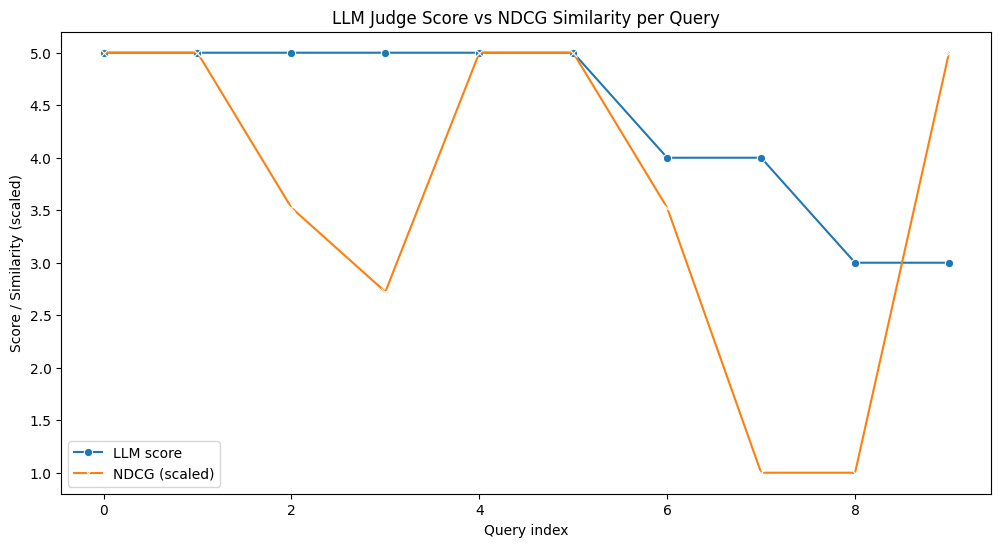

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your results (if not already loaded)
df = df#pd.read_json("data/eval/retrieval_llm_eval.json")

# Optional: normalize cosine similarity to 0-5 scale for better comparison
ndcg_min, ndcg_max = df["ndcg_at_k"].min(), df["ndcg_at_k"].max()
df["ndcg_scaled"] = 1 + 4 * (df["ndcg_at_k"] - ndcg_min) / (ndcg_max - ndcg_min)  # scale to [1,5]

# Sort queries by LLM score or any other metric if desired
df_sorted = df.sort_values("llm_score", ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df_sorted, x=range(len(df_sorted)), y="llm_score", marker="o", label="LLM score")
sns.lineplot(data=df_sorted, x=range(len(df_sorted)), y="ndcg_scaled", marker="x", label="NDCG (scaled)")
plt.xlabel("Query index")
plt.ylabel("Score / Similarity (scaled)")
plt.title("LLM Judge Score vs NDCG Similarity per Query")
plt.legend()
plt.show()